# 1. Import and Install Dependencies

In [ ]:
# references: https://github.com/nicknochnack/ActionDetectionforSignLanguage.git

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import time
import mediapipe as mp
import urllib.request
import tarfile
import pandas as pd
pd.options.mode.chained_assignment = None
import os

# 2. Keypoints using MP Holistic

In [2]:
mp_holistic = mp.solutions.holistic 
mp_drawing = mp.solutions.drawing_utils
mp_face_mesh = mp.solutions.face_mesh 

In [3]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR to RGB
    image.flags.writeable = False                  # Image is not writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB to BGR
    return image, results

In [4]:
def draw_styled_landmarks(image, results):
    # Draw face connections
    mp_drawing.draw_landmarks(image, results.face_landmarks,   mp_holistic.FACEMESH_CONTOURS, 
                             mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), 
                             mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
                             ) 
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             ) 
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             ) 

# 3. Extract Keypoint Values

In [5]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, face, lh, rh])

# 4. Setup Folders for Collection

In [7]:
# Path for exported data, numpy arrays
DATA_PATH = os.path.join('MP_Data') 

# Actions that we try to detect
actions = np.array(['hello', 'thank you', 'book'])

# 20 videos of data
num_sequences = 20

# Total sequences after augmentation (original + flipped + noisy)
num_augmented_sequences = num_sequences * 2  
total_sequences = num_sequences + num_augmented_sequences  

# Videos of 30 frames in length
sequence_length = 30

# Folder start
start_folder = 1

In [9]:
for action in actions: 
    action_path = os.path.join(DATA_PATH, action)
    os.makedirs(action_path, exist_ok=True)

    # Create subdirectories for each type of transformation
    for subfolder in ['original', 'flipped', 'noisy']:
        os.makedirs(os.path.join(action_path, subfolder), exist_ok=True)
        
      # Get existing sequence folders and find the highest folder number
    files = os.listdir(action_path)
    dirmax = max([int(f) for f in files if f.isdigit()], default=0)
    
    # Loop to create new sequence folders (for both original and augmented sequences)
    for sequence in range(start_folder, total_sequences + 1):
        sequence_folder = str(dirmax + sequence)
        sequence_folder_path = os.path.join(action_path, sequence_folder)
        
        # Create sequence folder and subdirectories
        os.makedirs(sequence_folder_path, exist_ok=True)
        
        # Create subdirectories under each sequence folder (if not already created)
        for subfolder in ['original', 'flipped', 'noisy']:
            os.makedirs(os.path.join(sequence_folder_path, subfolder), exist_ok=True)

print("Directories created successfully.")

Directories created successfully.


# 5. Collect Keypoint Values for Training and Testing

In [12]:
VID_PATH = os.path.join('data')

In [13]:
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    
    # NEW LOOP
    # Loop through actions
    for action in actions:
        # Loop through sequences aka videos
        for sequence in range(start_folder, start_folder+num_sequences):
            video_file = os.path.join(VID_PATH, action, f"{sequence}.mp4")
            if not os.path.exists(video_file):
                print(f"Skipping {video_file}, file not found.")
                continue

            cap = cv2.VideoCapture(video_file)
            
            # Loop through video length aka sequence length
            for frame_num in range(sequence_length):
                # Read feed
                ret, frame = cap.read()
                if not ret:
                    print(f"Warning: Missing frame {frame_num} in {video_file}")
                    break

                # Make detections
                image, results = mediapipe_detection(frame, holistic)

                # Draw landmarks
                draw_styled_landmarks(image, results)
                
                # Display collection status
                text = f"Collecting frames for {action}, Video {sequence}"
                cv2.putText(image, text, (15,12), 
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 225), 1, cv2.LINE_AA)
                cv2.imshow('OpenCV Feed', image)
                
                # Original keypoints
                keypoints = extract_keypoints(results)
                npy_path = os.path.join(DATA_PATH, action, str(sequence), 'original', f"{frame_num}.npy")
                np.save(npy_path, keypoints)

                # Data Augmentation: Horizontal Flip
                flipped_keypoints = keypoints.copy()
                flipped_keypoints[::3] *= -1  # Flip x-coordinates
                flipped_npy_path = os.path.join(DATA_PATH, action, str(sequence), 'flipped', f"{frame_num}.npy")
                np.save(flipped_npy_path, flipped_keypoints)

                # Data Augmentation: Add Noise
                noise = np.random.normal(0, 0.01, keypoints.shape)
                noisy_keypoints = keypoints + noise
                noisy_npy_path = os.path.join(DATA_PATH, action, str(sequence), 'noisy', f"{frame_num}.npy")
                np.save(noisy_npy_path, noisy_keypoints)

                # Break using q
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break
                    
            cap.release()
    cv2.destroyAllWindows()
print("Data collection and augmentation complete.")

Data collection and augmentation complete.


# 6. Preprocess Data and Create Labels and Features

In [14]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [16]:
label_map = {label:num for num, label in enumerate(actions)}

In [17]:
label_map

{'hello': 0, 'thank you': 1, 'book': 2}

In [19]:
sequences, labels = [], []
for action in actions:
    for sequence in range(1, num_sequences+1):
        # Initialize the list for storing frames in the current sequence
        original_window = []
        flipped_window = []
        noisy_window = []
        
        for frame_num in range(sequence_length):
            # Load the original keypoints for the current frame
            original_res = np.load(os.path.join(DATA_PATH, action, str(sequence), 'original', "{}.npy".format(frame_num)))
            original_window.append(original_res)

            # Load the flipped keypoints for the current frame
            flipped_res = np.load(os.path.join(DATA_PATH, action, str(sequence), 'flipped', "{}.npy".format(frame_num)))
            flipped_window.append(flipped_res)

            # Load the noisy keypoints for the current frame
            noisy_res = np.load(os.path.join(DATA_PATH, action, str(sequence), 'noisy', "{}.npy".format(frame_num)))
            noisy_window.append(noisy_res)

        # Append the original, flipped, and noisy windows to the sequences list
        sequences.append(original_window)  # Original sequence
        sequences.append(flipped_window)   # Flipped sequence
        sequences.append(noisy_window)     # Noisy sequence

        label = label_map[action]
        labels.append(label)  # Original sequence label
        labels.append(label)  # Flipped sequence label
        labels.append(label)  # Noisy sequence label

In [20]:
np.array(sequences).shape

(180, 30, 1662)

In [21]:
np.array(labels).shape

(180,)

In [22]:
X = np.array(sequences)

In [23]:
X.shape

(180, 30, 1662)

In [24]:
y = to_categorical(labels).astype(int)

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05)

In [26]:
y_test.shape

(9, 3)

# 7. Build and Train LSTM Neural Network

In [33]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import BatchNormalization
import tensorflow as tf

In [28]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [34]:
model = Sequential([
Input(shape=(30,1662)),
LSTM(64, return_sequences=True, activation='tanh'),
Dropout(0.2),  # Dropout to prevent overfitting, for regularization
LSTM(128, return_sequences=True, activation='tanh'),
Dropout(0.2),
LSTM(64, return_sequences=False, activation='tanh'),
Dropout(0.2),
Dense(64, activation='relu'),
BatchNormalization(),  # BatchNormalization to stabilize learning
Dropout(0.2),  # Dropout for regularization again
Dense(32, activation='relu'),
BatchNormalization(),
Dropout(0.2), 
Dense(actions.shape[0], activation='softmax'),
])

In [35]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [38]:
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

In [39]:
model.fit(X_train, y_train, epochs=2000, validation_data=(X_test, y_test), callbacks=[tb_callback, early_stopping])

Epoch 1/2000
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 0.4068 - loss: 1.2207 - val_accuracy: 0.3333 - val_loss: 1.0717
Epoch 2/2000
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - accuracy: 0.4173 - loss: 1.1015 - val_accuracy: 0.3333 - val_loss: 1.0790
Epoch 3/2000
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - accuracy: 0.3574 - loss: 1.1986 - val_accuracy: 0.4444 - val_loss: 1.0925
Epoch 4/2000
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - accuracy: 0.3493 - loss: 1.2602 - val_accuracy: 0.4444 - val_loss: 1.0859
Epoch 5/2000
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - accuracy: 0.3812 - loss: 1.2300 - val_accuracy: 0.3333 - val_loss: 1.0780
Epoch 6/2000
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - accuracy: 0.3155 - loss: 1.2543 - val_accuracy: 0.3333 - val_loss: 1.0833
Epoch 7/2000
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - accuracy: 0.4687 - loss: 1.0555 - val_accuracy: 0.4444 - val_loss: 1.0742
Epoch 8/2000
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - accuracy: 0.4458 - loss: 1.1608 - val_accuracy: 0.3333 - 

In [40]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                      ┃ Output Shape             ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                     │ (None, 30, 64)           │       442,112 │
├───────────────────────────────────┼──────────────────────────┼───────────────┤
│ dropout_3 (Dropout)               │ (None, 30, 64)           │             0 │
├───────────────────────────────────┼──────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                     │ (None, 30, 128)          │        98,816 │
├───────────────────────────────────┼──────────────────────────┼───────────────┤
│ dropout_4 (Dropout)               │ (None, 30, 128)          │             0 │
├───────────────────────────────────┼──────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                     │ (None, 64)               │        49,408 │
├───────────────────────────────────┼──────────────────────────┼───────────────┤
│ dropout_5 (Dropout)               │ (None, 64)               │             0 │
├───────────────────────────────────┼──────────────────────────┼───────────────┤
│ dense_1 (Dense)                   │ (None, 64)               │         4,160 │
├───────────────────────────────────┼──────────────────────────┼───────────────┤
│ batch_normalization               │ (None, 64)               │           256 │
│ (BatchNormalization)              │                          │               │
├───────────────────────────────────┼──────────────────────────┼───────────────┤
│ dropout_6 (Dropout)               │ (None, 64)               │             0 │
├───────────────────────────────────┼──────────────────────────┼───────────────┤
│ dense_2 (Dense)                   │ (None, 32)               │         2,080 │
├───────────────────────────────────┼──────────────────────────┼───────────────┤
│ batch_normalization_1             │ (None, 32)               │           128 │
│ (BatchNormalization)              │                          │               │
├───────────────────────────────────┼──────────────────────────┼───────────────┤
│ dropout_7 (Dropout)               │ (None, 32)               │             0 │
├───────────────────────────────────┼──────────────────────────┼───────────────┤
│ dense_3 (Dense)                   │ (None, 3)                │            99 │
└───────────────────────────────────┴──────────────────────────┴───────────────┘

 Total params: 1,790,795 (6.83 MB)

 Trainable params: 596,867 (2.28 MB)

 Non-trainable params: 192 (768.00 B)

 Optimizer params: 1,193,736 (4.55 MB)

# 8. Make Predictions

In [50]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

In [41]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 1.0000 - loss: 0.0112
Test Loss: 0.011220559477806091
Test Accuracy: 1.0


In [42]:
# 2. Prediction on test set
res = model.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 891ms/step


In [45]:
# Print predicted class labels (if classification)
y_pred_classes = np.argmax(res, axis=1)

# Print true class labels
y_true_classes = np.argmax(y_test, axis=1)

In [46]:
print("Predicted labels:", y_pred_classes)
print("True labels:", y_true_classes)

Predicted labels: [1 2 2 2 1 1 2 0 0]
True labels: [1 2 2 2 1 1 2 0 0]


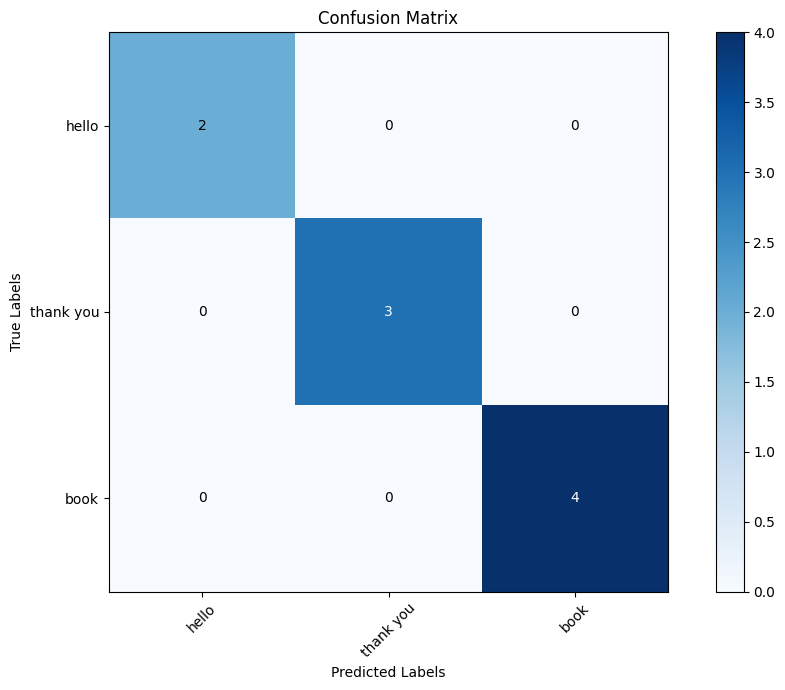

In [51]:
# 3. confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

# Add class labels (actions)
tick_marks = np.arange(len(actions))
plt.xticks(tick_marks, actions, rotation=45)
plt.yticks(tick_marks, actions)

# Add labels and title
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

# Annotate each cell in the matrix
thresh = cm.max() / 2.
for i in range(len(actions)):
    for j in range(len(actions)):
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center", color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.show()

# 9. Save Weights

In [53]:
# Save the model to a file
model.save('sign_language_model.keras')

In [101]:
# Save the model to a file
model.save('sign_language_model.h5')

# 10. Evaluation using Confusion Matrix and Accuracy

In [54]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [55]:
yhat = model.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


In [56]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [57]:
multilabel_confusion_matrix(ytrue, yhat)

array([[[7, 0],
        [0, 2]],

       [[6, 0],
        [0, 3]],

       [[5, 0],
        [0, 4]]], dtype=int64)

In [58]:
accuracy_score(ytrue, yhat)

1.0

# 11. Test in Real Time

In [36]:
from scipy import stats
import cv2
import numpy as np
import torch
import torchvision.models as models

In [59]:
def prob_viz(res, actions, input_frame, colors):
    # Find the index of the highest probability
    max_prob_index = np.argmax(res)
    max_prob_value = res[max_prob_index]
    sign = actions[max_prob_index]
    
    # Convert probability to 2 decimal places
    prob_value = f"{max_prob_value:.2f}"
    
    # Return the sign and its probability value
    return sign, prob_value

In [105]:
# 1. New detection variables
sequence = []
sentence = []
predictions = []
threshold = 0.5
# Prompt the user for the video file path
video_file = input("Please enter the path to the video file (without extension): ")
input_folder = "test_input_data"

# Create the full video file path by appending the extension
video_path = os.path.join(input_folder, f"{video_file}.mp4")

# Check if the video file exists
if not os.path.exists(video_path):
    print(f"Error: Video file '{video_filename}.mp4' not found in the '{input_folder}' folder.")
    exit()

cap = cv2.VideoCapture(video_path)
if not cap.isOpened():
    print(f"Error: Failed to open video file at {video_path}")
    exit()
    
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Check if video has frames to read
        frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        print(f"Video contains {frame_count} frames.")
        
        # Read feed
        ret, frame = cap.read()
        if not ret:
            break

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        
        # Extract keypoints and append to sequence
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]  # Keep only the latest 30 frames

        
        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]

            # Display the predicted action
            predicted_action, prob_value = prob_viz(res, actions, frame, colors)
            
            # Output the result to the console
            print(f"Predicted sign: {predicted_action}, Probability: {prob_value}")
            
            # Return predicted sign and probability (for function)
            # return predicted_sign, prob_value
  
        # Break with q
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

Please enter the path to the video file (without extension):  hello


Video contains 36 frames.
Video contains 36 frames.
Video contains 36 frames.
Video contains 36 frames.
Video contains 36 frames.
Video contains 36 frames.
Video contains 36 frames.
Video contains 36 frames.
Video contains 36 frames.
Video contains 36 frames.
Video contains 36 frames.
Video contains 36 frames.
Video contains 36 frames.
Video contains 36 frames.
Video contains 36 frames.
Video contains 36 frames.
Video contains 36 frames.
Video contains 36 frames.
Video contains 36 frames.
Video contains 36 frames.
Video contains 36 frames.
Video contains 36 frames.
Video contains 36 frames.
Video contains 36 frames.
Video contains 36 frames.
Video contains 36 frames.
Video contains 36 frames.
Video contains 36 frames.
Video contains 36 frames.
Video contains 36 frames.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/step
Predicted sign: hello, Probability: 1.00
Video contains 36 frames.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Predicted sign: hello, Probability: 1.00
Video contains 36 frames.
1/1 ━━━━━

# 11. Convert Model to .tflite file for android use

In [104]:
model = tf.keras.models.load_model('sign_language_model.keras')

C:\Users\tanad\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 21 variables whereas the saved optimizer has 40 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [107]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.experimental_new_converter=True
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, 
                                          tf.lite.OpsSet.SELECT_TF_OPS]
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: C:\Users\tanad\AppData\Local\Temp\tmpta2mdlvj\assets


INFO:tensorflow:Assets written to: C:\Users\tanad\AppData\Local\Temp\tmpta2mdlvj\assets


Saved artifact at 'C:\Users\tanad\AppData\Local\Temp\tmpta2mdlvj'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 30, 1662), dtype=tf.float32, name='input_layer_2')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  1424725710736: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1424725706896: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1424725705936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1424704751376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1424704751952: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1424704752336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1424704750032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1424725710544: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1424725712464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1424725707472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1424725

In [108]:
 # Saving the model.
mpath ='sign_language_model.tflite'
with open(mpath, 'wb') as f:
    f.write(tflite_model)

In [84]:
# reference: https://github.com/amir-abdi/keras_to_tensorflow/blob/master/keras_to_tensorflow.py

In [95]:
# Input
import argparse
parser = argparse.ArgumentParser(description='set input arguments')
parser.add_argument('-input_fld', action="store", 
                    dest='input_fld', type=str, default='.')
parser.add_argument('-output_fld', action="store", 
                    dest='output_fld', type=str, default='')
parser.add_argument('-input_model_file', action="store", 
                    dest='input_model_file', type=str, default='model.h5')
parser.add_argument('-output_model_file', action="store", 
                    dest='output_model_file', type=str, default='')
parser.add_argument('-output_graphdef_file', action="store", 
                    dest='output_graphdef_file', type=str, default='model.ascii')
parser.add_argument('-num_outputs', action="store", 
                    dest='num_outputs', type=int, default=1)
parser.add_argument('-graph_def', action="store", 
                    dest='graph_def', type=bool, default=False)
parser.add_argument('-output_node_prefix', action="store", 
                    dest='output_node_prefix', type=str, default='output_node')
parser.add_argument('-quantize', action="store", 
                    dest='quantize', type=bool, default=False)
parser.add_argument('-theano_backend', action="store", 
                    dest='theano_backend', type=bool, default=False)
parser.add_argument('-f')
args = parser.parse_args()
parser.print_help()
print('input args: ', args)

if args.theano_backend is True and args.quantize is True:
    raise ValueError("Quantize feature does not work with theano backend.")
parser = argparse.ArgumentParser(description='set input arguments')
parser.add_argument('-input_fld', action="store", 
                    dest='input_fld', type=str, default='.')
parser.add_argument('-output_fld', action="store", 
                    dest='output_fld', type=str, default='')
parser.add_argument('-input_model_file', action="store", 
                    dest='input_model_file', type=str, default='sign_language_model.keras')
parser.add_argument('-output_model_file', action="store", 
                    dest='output_model_file', type=str, default='')
parser.add_argument('-output_graphdef_file', action="store", 
                    dest='output_graphdef_file', type=str, default='model.ascii')
parser.add_argument('-num_outputs', action="store", 
                    dest='num_outputs', type=int, default=1)
parser.add_argument('-graph_def', action="store", 
                    dest='graph_def', type=bool, default=False)
parser.add_argument('-output_node_prefix', action="store", 
                    dest='output_node_prefix', type=str, default='output_node')
parser.add_argument('-quantize', action="store", 
                    dest='quantize', type=bool, default=False)
parser.add_argument('-theano_backend', action="store", 
                    dest='theano_backend', type=bool, default=False)
parser.add_argument('-f')
args = parser.parse_args()
parser.print_help()
print('input args: ', args)

if args.theano_backend is True and args.quantize is True:
    raise ValueError("Quantize feature does not work with theano backend.")

usage: ipykernel_launcher.py [-h] [-input_fld INPUT_FLD] [-output_fld OUTPUT_FLD]
                             [-input_model_file INPUT_MODEL_FILE]
                             [-output_model_file OUTPUT_MODEL_FILE]
                             [-output_graphdef_file OUTPUT_GRAPHDEF_FILE]
                             [-num_outputs NUM_OUTPUTS] [-graph_def GRAPH_DEF]
                             [-output_node_prefix OUTPUT_NODE_PREFIX]
                             [-quantize QUANTIZE]
                             [-theano_backend THEANO_BACKEND] [-f F]

set input arguments

options:
  -h, --help            show this help message and exit
  -input_fld INPUT_FLD
  -output_fld OUTPUT_FLD
  -input_model_file INPUT_MODEL_FILE
  -output_model_file OUTPUT_MODEL_FILE
  -output_graphdef_file OUTPUT_GRAPHDEF_FILE
  -num_outputs NUM_OUTPUTS
  -graph_def GRAPH_DEF
  -output_node_prefix OUTPUT_NODE_PREFIX
  -quantize QUANTIZE
  -theano_backend THEANO_BACKEND
  -f F
input args:  Namespace(input_fld='

In [96]:
# Initialize

from keras.models import load_model
import tensorflow as tf
from pathlib import Path
from keras import backend as K

# Parse the arguments
args = parser.parse_args()

output_fld =  args.input_fld if args.output_fld == '' else args.output_fld
if args.output_model_file == '':
    args.output_model_file = str(Path(args.input_model_file).name) + '.pb'
Path(output_fld).mkdir(parents=True, exist_ok=True)    
weight_file_path = str(Path(args.input_fld) / args.input_model_file)

In [ ]:
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

In [97]:
# Load Model

if args.theano_backend:
    K.set_image_data_format('channels_first')
else:
    K.set_image_data_format('channels_last')

try:
    net_model = load_model(weight_file_path)
except ValueError as err:
    print('''Input file specified ({}) only holds the weights, and not the model defenition.
    Save the model using mode.save(filename.h5) which will contain the network architecture
    as well as its weights. 
    If the model is saved using model.save_weights(filename.h5), the model architecture is 
    expected to be saved separately in a json format and loaded prior to loading the weights.
    Check the keras documentation for more details (https://keras.io/getting-started/faq/)'''
          .format(weight_file_path))
    raise err
num_output = args.num_outputs
pred = [None]*num_output
pred_node_names = [None]*num_output
for i in range(num_output):
    pred_node_names[i] = args.output_node_prefix+str(i)
    pred[i] = tf.identity(net_model.outputs[i], name=pred_node_names[i])
print('output nodes names are: ', pred_node_names)

C:\Users\tanad\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 21 variables whereas the saved optimizer has 40 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


ValueError: A KerasTensor cannot be used as input to a TensorFlow function. A KerasTensor is a symbolic placeholder for a shape and dtype, used when constructing Keras Functional models or Keras Functions. You can only use it as input to a Keras layer or a Keras operation (from the namespaces `keras.layers` and `keras.operations`). You are likely doing something like:

```
x = Input(...)
...
tf_fn(x)  # Invalid.
```

What you should do instead is wrap `tf_fn` in a layer:

```
class MyLayer(Layer):
    def call(self, x):
        return tf_fn(x)

x = MyLayer()(x)
```


In [ ]:
# convert variables to constants and save
from tensorflow.python.framework import graph_util
from tensorflow.python.framework import graph_io
from tensorflow.tools.graph_transforms import TransformGraph
if args.quantize:
    transforms = ["quantize_weights", "quantize_nodes"]
    transformed_graph_def = TransformGraph(sess.graph.as_graph_def(), [], pred_node_names, transforms)
    constant_graph = graph_util.convert_variables_to_constants(sess, transformed_graph_def, pred_node_names)
else:
    constant_graph = graph_util.convert_variables_to_constants(sess, sess.graph.as_graph_def(), pred_node_names)    
graph_io.write_graph(constant_graph, output_fld, args.output_model_file, as_text=False)
print('saved the freezed graph (ready for inference) at: ', str(Path(output_fld) / args.output_model_file))